<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/rodrigo_cabrera_castaldoni/Aula_6_Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = "Rodrigo Cabrera Castaldoni"

print(f'Meu nome é {nome}')

Meu nome é Rodrigo Cabrera Castaldoni


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [4]:
batch_size = 50

## Download do CIFAR-10

In [5]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [6]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

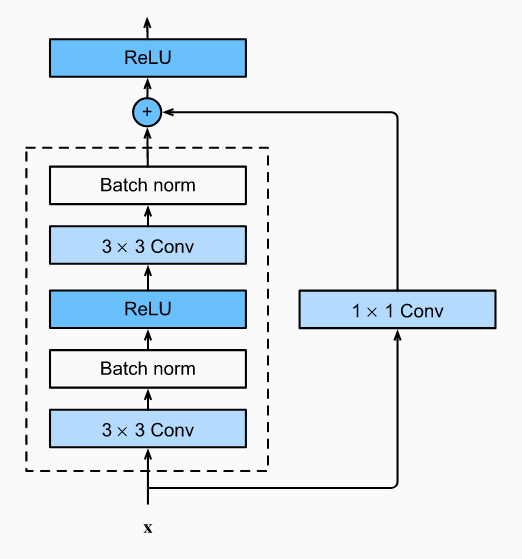

In [8]:
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(self, inplanes: int, planes: int, stride: int = 1) -> None:
        super().__init__()
        self.kernel_size = 3 # ref: https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278
        self.relu = nn.ReLU()
        self.block = nn.Sequential(self.basic_conv_norm(inplanes, planes, stride),
                                   self.relu,
                                   self.basic_conv_norm(planes, planes, 1))
        
        self.residual = nn.Conv2d(in_channels=inplanes, 
                                  out_channels=planes, 
                                  kernel_size=1,
                                  padding=0,
                                  stride=stride, 
                                  groups=1, 
                                  bias=False, 
                                  dilation=1)
        
    def basic_conv_norm(self, in_channels, out_channels, stride):
        return nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                       out_channels=out_channels, 
                                       kernel_size=self.kernel_size,
                                       padding=self.kernel_size//2,
                                       stride=stride, 
                                       groups=1, 
                                       bias=False, 
                                       dilation=1),
                            nn.BatchNorm2d(num_features=out_channels)
        )

        
    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        """
        O block perde dimensão devido as as camadas convolucionais com kernel size > 1
        enquanto que o bloco residual utiliza o stride para fazer o match da dimensão de output das camadas de convolução.
        
        Para fazer tudo conversar precisamos utilizar o padding nas camadas convolucionais de acordo com o tamanho do kernel
        """

        return self.relu(self.block(x) + self.residual(x))


## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [9]:
import torchvision
from collections import OrderedDict

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)
block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)
# print(block(x).shape)
downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)
block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# ADICIONEI ESSE PEDACO DE CODIGO PARA PODER FAZER O LOAD DOS PESOS NA MINHA REDE
torchlayername2myname = {block_pytorch_name:my_name 
                         for block_pytorch_name, my_name in zip(block_pt.state_dict().keys(), block.state_dict().keys())}

torch_state_dict_with_my_name = OrderedDict({torchlayername2myname[torchlayername]:weights 
                                         for torchlayername, weights in block_pt.state_dict().items()})

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(torch_state_dict_with_my_name)

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [11]:
"""
Tentando melhora a métrica do modelo me inspirei no código do Leonardo Pacheco.
"""

class Net(torch.nn.Module):

    def __init__(self, inplanes: int, stride: int = 1, n_residual_blocks: int = 3):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.residual_block1 = MyBasicBlock(inplanes, 32, stride)
        self.intermediate_residual_blocks = nn.ModuleList([MyBasicBlock(32,32,stride) for _ in range(n_residual_blocks)])
        self.residual_block2 = MyBasicBlock(32, 64, stride)
        self.pooling = nn.MaxPool2d(3,3)
        self.linear = nn.Linear(in_features=64*3*3, out_features=10)
        
    def forward(self, x):
        # Escreva seu código aqui.
        
        """
        Nesse caso como vamos utilizar um criterion Cross Entropy temos que devolver os logitos
        """
        out = self.residual_block1(x)
        out = self.pooling(out)
        for intermediate_residual_block in self.intermediate_residual_blocks:
          out = intermediate_residual_block(out)
        out = self.residual_block2(out)
        out = self.pooling(out)
        out = self.linear(out.reshape(out.shape[0], -1))

        return out

## Treinamento

### Definição dos hiperparâmetros

In [12]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda')

In [14]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    model.eval()
    with torch.no_grad():
        n_correct_samples = 0
        n_total_samples = 0 # len(loader)
        for input_valid, target_valid in tqdm(loader):
            input_valid = input_valid.to(device)
            target_valid = target_valid.to(device)

            yhat_valid = model(input_valid)
            
            n_correct_samples += sum(yhat_valid.argmax(dim=1) == target_valid)
            n_total_samples += len(target_valid)

    mean_accuracy = n_correct_samples/n_total_samples
    print(f'\nAccuracy: {mean_accuracy}')

### Laço de treinamento

In [15]:
from tqdm import tqdm


model = Net(3, stride=1, n_residual_blocks=8)

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

100%|██████████| 200/200 [00:03<00:00, 57.99it/s]



Accuracy: 0.09730000048875809


Training: 100%|██████████| 800/800 [00:21<00:00, 36.79it/s]


Epoch: 0/19 Loss: 1.2977710962295532


100%|██████████| 200/200 [00:03<00:00, 60.65it/s]



Accuracy: 0.48579999804496765


Training: 100%|██████████| 800/800 [00:22<00:00, 36.01it/s]


Epoch: 1/19 Loss: 1.3994182348251343


100%|██████████| 200/200 [00:03<00:00, 60.92it/s]



Accuracy: 0.5412999987602234


Training: 100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


Epoch: 2/19 Loss: 1.182472825050354


100%|██████████| 200/200 [00:03<00:00, 61.29it/s]



Accuracy: 0.5841999650001526


Training: 100%|██████████| 800/800 [00:21<00:00, 36.90it/s]


Epoch: 3/19 Loss: 0.9442310929298401


100%|██████████| 200/200 [00:03<00:00, 61.01it/s]



Accuracy: 0.6416999697685242


Training: 100%|██████████| 800/800 [00:21<00:00, 36.88it/s]


Epoch: 4/19 Loss: 1.0254734754562378


100%|██████████| 200/200 [00:03<00:00, 60.21it/s]



Accuracy: 0.62909996509552


Training: 100%|██████████| 800/800 [00:21<00:00, 37.24it/s]


Epoch: 5/19 Loss: 0.6216607093811035


100%|██████████| 200/200 [00:03<00:00, 61.11it/s]



Accuracy: 0.6784999966621399


Training: 100%|██████████| 800/800 [00:22<00:00, 36.28it/s]


Epoch: 6/19 Loss: 0.6948343515396118


100%|██████████| 200/200 [00:03<00:00, 59.19it/s]



Accuracy: 0.6940999627113342


Training: 100%|██████████| 800/800 [00:21<00:00, 36.49it/s]


Epoch: 7/19 Loss: 0.5934138298034668


100%|██████████| 200/200 [00:03<00:00, 59.50it/s]



Accuracy: 0.7066999673843384


Training: 100%|██████████| 800/800 [00:21<00:00, 36.46it/s]


Epoch: 8/19 Loss: 0.5937693119049072


100%|██████████| 200/200 [00:03<00:00, 60.82it/s]



Accuracy: 0.7123000025749207


Training: 100%|██████████| 800/800 [00:21<00:00, 37.18it/s]


Epoch: 9/19 Loss: 0.5525799989700317


100%|██████████| 200/200 [00:03<00:00, 60.32it/s]



Accuracy: 0.6653000116348267


Training: 100%|██████████| 800/800 [00:21<00:00, 36.71it/s]


Epoch: 10/19 Loss: 0.5725064873695374


100%|██████████| 200/200 [00:03<00:00, 61.23it/s]



Accuracy: 0.73089998960495


Training: 100%|██████████| 800/800 [00:21<00:00, 36.70it/s]


Epoch: 11/19 Loss: 0.5432443022727966


100%|██████████| 200/200 [00:03<00:00, 60.78it/s]



Accuracy: 0.6870999932289124


Training: 100%|██████████| 800/800 [00:21<00:00, 37.15it/s]


Epoch: 12/19 Loss: 0.48357850313186646


100%|██████████| 200/200 [00:03<00:00, 60.49it/s]



Accuracy: 0.7112999558448792


Training: 100%|██████████| 800/800 [00:21<00:00, 36.96it/s]


Epoch: 13/19 Loss: 0.3751142621040344


100%|██████████| 200/200 [00:03<00:00, 61.28it/s]



Accuracy: 0.7361999750137329


Training: 100%|██████████| 800/800 [00:21<00:00, 37.00it/s]


Epoch: 14/19 Loss: 0.4191697835922241


100%|██████████| 200/200 [00:03<00:00, 60.25it/s]



Accuracy: 0.7287999987602234


Training: 100%|██████████| 800/800 [00:21<00:00, 37.06it/s]


Epoch: 15/19 Loss: 0.44277650117874146


100%|██████████| 200/200 [00:03<00:00, 60.54it/s]



Accuracy: 0.7376999855041504


Training: 100%|██████████| 800/800 [00:21<00:00, 36.90it/s]


Epoch: 16/19 Loss: 0.40369927883148193


100%|██████████| 200/200 [00:03<00:00, 61.76it/s]



Accuracy: 0.7483999729156494


Training: 100%|██████████| 800/800 [00:21<00:00, 36.98it/s]


Epoch: 17/19 Loss: 0.3310844302177429


100%|██████████| 200/200 [00:03<00:00, 61.02it/s]



Accuracy: 0.73089998960495


Training: 100%|██████████| 800/800 [00:21<00:00, 37.02it/s]


Epoch: 18/19 Loss: 0.5994970798492432


100%|██████████| 200/200 [00:03<00:00, 61.64it/s]



Accuracy: 0.7462999820709229


Training: 100%|██████████| 800/800 [00:21<00:00, 37.00it/s]


Epoch: 19/19 Loss: 0.44947347044944763


100%|██████████| 200/200 [00:03<00:00, 60.85it/s]


Accuracy: 0.7322999835014343


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

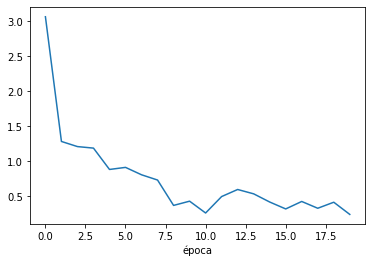

In [16]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [17]:
evaluation(model=model, loader=test_dataloader)

100%|██████████| 200/200 [00:04<00:00, 41.73it/s]


Accuracy: 0.7366999983787537


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)